In [95]:
%matplotlib inline
import glob
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.feature import greycomatrix, greycoprops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import pandas as pd

Text(0.5, 1.0, 'ACA')

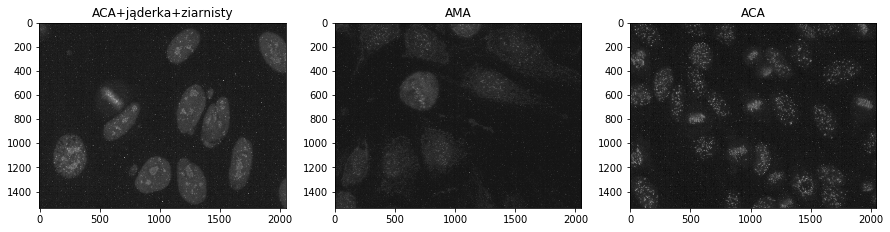

In [3]:
aca_jz = cv.imread('./data/sample/ACA+jąderka+ziarnisty(HEp2IIF)1.png')
ama = cv.imread('./data/sample/aca+ama.png')
aca = cv.imread('./data/sample/ACA-1.png')
aca_jz_gray = cv.cvtColor(aca_jz, cv.COLOR_BGR2GRAY)
ama_gray = cv.cvtColor(ama, cv.COLOR_BGR2GRAY)
aca_gray = cv.cvtColor(aca, cv.COLOR_BGR2GRAY)

f, axes = plt.subplots(1, 3)
f.set_size_inches(15, 5)

axes[0].imshow(aca_jz_gray, cmap='gray')
axes[0].set_title('ACA+jąderka+ziarnisty')

axes[1].imshow(ama_gray, cmap='gray')
axes[1].set_title('AMA')

axes[2].imshow(aca_gray, cmap='gray')
axes[2].set_title('ACA')

In [4]:
def preprocess(img, size):
    img = img.copy()
    
    #resizing and denoising
    img = cv.resize(img, dsize=size, interpolation=cv.INTER_CUBIC)
    img = cv.fastNlMeansDenoising(img, h=5)
    
    # normalization
    min_ = np.amin(img)
    max_ = np.amax(img)
    norm = (img - min_) * (255 / (max_ - min_))
    return norm.astype(np.uint)

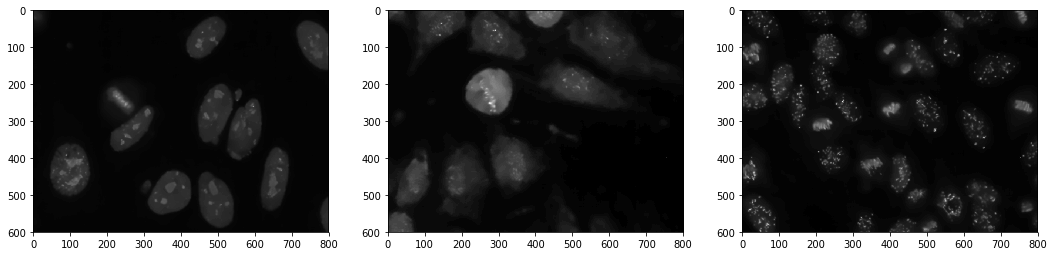

In [5]:
size = (800, 600)
norm_aca_jz = preprocess(aca_jz_gray, size)
norm_ama = preprocess(ama_gray, size)
norm_aca = preprocess(aca_gray, size)

f, a = plt.subplots(1, 3)
f.set_size_inches(18, 6)
a[0].imshow(norm_aca_jz, cmap='gray')
a[1].imshow(norm_ama, cmap='gray')
a[2].imshow(norm_aca, cmap='gray')

# texture features extraction:

In [127]:
def texture_features(img, locs, rows, cols, stride, params):
    results = [[] for _ in range(len(params))]
    
    for loc in locs:
        top, left = loc
        
        for r in range(rows):
            for c in range(cols):
                t = top + r * stride
                l = left + c * stride
                patch = img[t:t+stride, l:l+stride] / 255 * 8
                patch = patch.astype(np.int8)

                glcm = greycomatrix(patch, [5], [0], levels=9, symmetric=True, normed=True)
                
                for i, p in enumerate(params):
                    results[i].append(greycoprops(glcm, p)[0, 0])

    return np.array(results)

def get_shade(img, locs, size, shade=None):
    
    if shade is None:
        shade = np.zeros(img.shape)
        
    for loc in locs:
        top, left = loc
        height, width = size
        shade[top:top+height, left:left+width] = 255
        
    return shade


def perform_pca(data, number_of_components, scale=False):
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    pca = PCA(n_components=number_of_components)
    components = pca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    
    return components_dataframe, pca

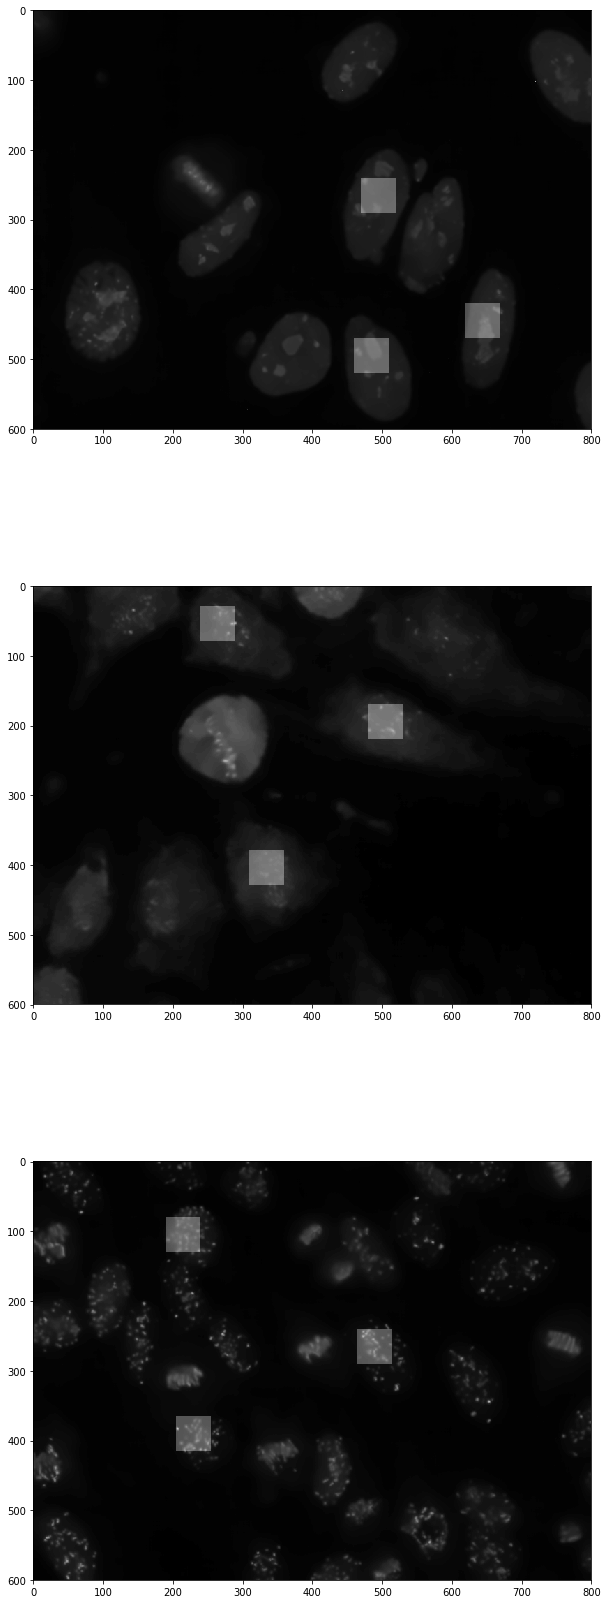

In [132]:
rows, cols = 1, 1
stride = 50
height, width = stride * rows, stride * cols

locs_aca_jz = [
    (240, 470),
    (470, 460),
    (420, 620)
]

locs_ama = [
    (30, 240),
    (380, 310),
    (170, 480)
]

locs_aca = [
    (80, 190),
    (365, 205),
    (240, 465)
]

shade1 = get_shade(norm_aca_jz, locs_aca_jz, (height, width))
shade2 = get_shade(norm_ama, locs_ama, (height, width))
shade3 = get_shade(norm_aca, locs_aca, (height, width))

f, a = plt.subplots(3, 1)
f.set_size_inches(10, 30)

a[0].imshow(norm_aca_jz, cmap='gray')
a[0].imshow(shade1, cmap='gray', alpha=0.3)

a[1].imshow(norm_ama, cmap='gray')
a[1].imshow(shade2, cmap='gray', alpha=0.3)

a[2].imshow(norm_aca, cmap='gray')
a[2].imshow(shade3, cmap='gray', alpha=0.3)

In [133]:
colors = ['red', 'blue', 'green']
p = ['dissimilarity', 'correlation', 'contrast', 'ASM', 'homogeneity']
features1 = texture_features(norm_aca_jz, locs_aca_jz, rows, cols, stride, p)
features2 = texture_features(norm_ama, locs_ama, rows, cols, stride, p)
features3 = texture_features(norm_aca, locs_aca, rows, cols, stride, p)
f_combined = np.concatenate([features1, features2, features3], axis=1)
#f_combined = np.concatenate([features1, features2], axis=1)

f_length = features1[0].shape[0]

In [134]:
f_combined

array([[0.09955556, 0.17866667, 0.23777778, 0.21288889, 0.19466667,
        0.232     , 0.31377778, 0.44844444, 0.51911111],
       [0.28414378, 0.39476061, 0.54503802, 0.33532104, 0.60431108,
        0.56060097, 0.42088284, 0.37993904, 0.37527378],
       [0.09955556, 0.17866667, 0.23777778, 0.26088889, 0.19644444,
        0.26933333, 0.35288889, 0.64844444, 0.75555556],
       [0.77288514, 0.55805511, 0.39101383, 0.58108385, 0.35084484,
        0.32877156, 0.35506015, 0.22971269, 0.22543249],
       [0.95022222, 0.91066667, 0.88111111, 0.89829281, 0.90284444,
        0.88773333, 0.84702222, 0.7950538 , 0.76383791]])

In [135]:
components, _ = perform_pca(f_combined.T, number_of_components=2, scale=True)
components

,0,1
0,-2.973780,-1.601056
1,-1.494402,-0.361293
2,-0.359218,1.151871
3,-1.114160,-1.046175
4,-0.717753,1.861089
5,-0.197666,1.418575
6,0.619529,-0.041732
7,2.695047,-0.569025
8,3.542402,-0.812254


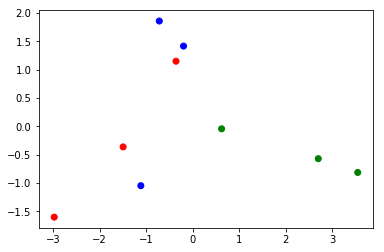

In [136]:
colors_list = [[c] * f_length for c in colors]
colors_list = np.concatenate(colors_list)

plt.scatter(components[0], components[1], c=colors_list)